In [4]:
# General
import numpy as np
import pickle as pk
import math

# For optimization
import pygmo as pg

# For computing acceleration and potential
import polyhedral_gravity as model

# For working with the mesh
import mesh_utility
import tetgen
import meshio as mio
import openmesh as om

# For Plotting
import pyvista as pv
import mesh_plotting
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import cm


class basic_udp:
    
    def fitness(self,x):

        # Initial information
        r = np.transpose(x[0:3]) # Start Position
        v = np.transpose(x[3:6]) # Initial velocity

        # Creating the mesh (TetGen)
        mesh, vertices, faces = mesh_utility.create_mesh()

        # Defining additional parameters
        density = 533           # https://sci.esa.int/web/rosetta/-/14615-comet-67p
        target_altitude = 10    # In unit: [km]
        t_end = 100            # Final time
        t_0 = 0                 # Starting time
        d_t = 1                # Number of steps along orbit 

        # Array containing times for summation
        time_list = np.arange(t_0,t_end,d_t)

        # Fitness value (to be maximized)
        fit_val = 0

        
        for t in time_list:
            # Retrieve information at current position
            altitude = compute_Altitude(r, mesh)
            potential, a, tensor = model.evaluate(vertices, faces, density, r)
            a = np.array(a)

            # Computing velocity and position for next time-step
            v_n = v + d_t * a
            r_n = r + d_t * v

            # Evaluate current position
            fit_val += abs(target_altitude - altitude)

            # Update current velocity and position
            v = v_n
            r = r_n

        return [fit_val]


    def get_bounds(self):
        # Bounds for the initial domain (i.e bounds for possible x-chromosomes)
        #   min=[r_x,r_y,r_z,v_x,v_y,v_z], max=[r_x,r_y,r_z,v_x,v_y,v_z]
        # Good starting boundaries could e.g be right outside the most protruding part of the the mesh 
        return ([4000,4000,4000,10,10,10],[10000,10000,10000,800,800,800])



def compute_Altitude(r,mesh):
    # Obtaining closest distance from mesh to satelite: 
    #    See PyVista function: https://docs.pyvista.org/api/core/_autosummary/pyvista.DataSet.find_closest_point.html
    index = mesh.grid.find_closest_point(r) 
    closest_point = mesh.grid.points[index]
    altitude = np.linalg.norm(closest_point-r)
    return altitude



def get_trajectory(mesh, vertices, faces, x):

    #to be finished.

    # Initial information
    r = np.transpose(x[0:3]) # Start Position
    v = np.transpose(x[3:6]) # Initial velocity

    # Defining additional parameters
    density = 533           # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    target_altitude = 10    # In unit: [km]
    t_end = 100             # Final time
    t_0 = 0                 # Starting time
    d_t = 1                 # Number of steps along orbit 

    # Array containing times for summation
    time_list = np.arange(t_0,t_end,d_t)
    
    # Numpy Arrays to store trajectory information
    r_store = np.zeros((3,len(time_list)))
    v_store = np.zeros((3,len(time_list)))

    # Add starting position to memory
    r_store[:,0] = r
    v_store[:,0] = v

    for i in range(0,len(time_list)):

        # Retrieve information at current position
        altitude = compute_Altitude(r, mesh)
        potential, a, tensor = model.evaluate(vertices, faces, density, r)
        a = np.array(a)

        # Computing velocity and position for next time-step
        v_n = v + d_t * a
        r_n = r + d_t * v

        # Update current velocity and position
        v = v_n
        r = r_n

        # Storing updated trajectory information
        r_store[:,i] = r
        v_store[:,i] = v
        i += 1

    return r_store, v_store



def plot_trajectory(mesh, vertices, faces, r_store):

    # Plotting mesh of asteroid/comet
    mesh_plot = pv.Plotter()
    mesh_plot.add_mesh(mesh.grid, show_edges=True)
    mesh_plot.show_bounds(grid='front',location='outer',all_edges=True)

    # Plotting trajectory
    trajectory_plot = pv.PolyData(np.transpose(r_store))
    mesh_plot.add_mesh(trajectory_plot, color=[0.6, 0.2, 0.1])

    mesh_plot.show(jupyter_backend='static')


def plot_evolutions():
    ...




In [5]:

# Defining and executing optimization
prob = pg.problem(basic_udp())
print(prob)

Problem name: <class '__main__.basic_udp'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [4000, 4000, 4000, 10, 10, ... ]
	Upper bounds: [10000, 10000, 10000, 800, 800, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [6]:
algo = pg.algorithm(pg.de(gen = 20))
pop = pg.population(prob = basic_udp(), size = 5)

Reading file...
Physical dimension along x (UN-normalized):  5002.5703125 Km
Tetrahralize...
Writing vtk files...
Writing polyhedron-cpp input files..
Writing FORTRAN files..
Writing other files...
Finished.
I'm at time:  0
Value of v:  [513.6405556  662.58413008 191.98956776] <class 'numpy.ndarray'> ,   Value of a:  [1.25300006e-05 1.45651299e-05 1.41284135e-05] <class 'numpy.ndarray'> ,    Value of r:  [4401.91663805 5436.81657822 4962.97410141] <class 'numpy.ndarray'> ,    Value of d_t:  1 <class 'int'>
This is the fit value:  5555.863129376588
I'm at time:  1
Value of v:  [513.64056813 662.58414464 191.98958189] <class 'numpy.ndarray'> ,   Value of a:  [1.06722561e-05 1.25892645e-05 1.11881703e-05] <class 'numpy.ndarray'> ,    Value of r:  [4915.55719365 6099.4007083  5154.96366916] <class 'numpy.ndarray'> ,    Value of d_t:  1 <class 'int'>
This is the fit value:  11899.450456944414
I'm at time:  2
Value of v:  [513.6405788  662.58415723 191.98959307] <class 'numpy.ndarray'> ,   V

In [7]:
pop = algo.evolve(pop)

Reading file...
Physical dimension along x (UN-normalized):  5002.5703125 Km
Tetrahralize...
Writing vtk files...
Writing polyhedron-cpp input files..
Writing FORTRAN files..
Writing other files...
Finished.
I'm at time:  0
Value of v:  [513.6405556  662.58413008 634.67737079] <class 'numpy.ndarray'> ,   Value of a:  [1.25300006e-05 1.45651299e-05 1.41284135e-05] <class 'numpy.ndarray'> ,    Value of r:  [4401.91663805 5436.81657822 4962.97410141] <class 'numpy.ndarray'> ,    Value of d_t:  1 <class 'int'>
This is the fit value:  5555.863129376588
I'm at time:  1
Value of v:  [513.64056813 662.58414464 634.67738492] <class 'numpy.ndarray'> ,   Value of a:  [9.81811579e-06 1.16060710e-05 1.11914864e-05] <class 'numpy.ndarray'> ,    Value of r:  [4915.55719365 6099.4007083  5597.6514722 ] <class 'numpy.ndarray'> ,    Value of d_t:  1 <class 'int'>
This is the fit value:  12150.848343739033
I'm at time:  2
Value of v:  [513.64057795 662.58415625 634.67739611] <class 'numpy.ndarray'> ,   V

[1347073.09684277]
[4816.7855022  4700.51451185 4767.67082969  141.54798417   91.55356654
   26.62545758]
Reading file...
Physical dimension along x (UN-normalized):  5002.5703125 Km
Tetrahralize...
Writing vtk files...
Writing polyhedron-cpp input files..
Writing FORTRAN files..
Writing other files...
Finished.
r_store size:  ( 3 , 100 )
v_store size:  ( 3 , 100 )
Iteration:  0
Current r:  [4958.33348636 4792.06807839 4794.29628727]
Current r:  [141.54799942  91.55358051  26.62547271]
r_store size:  ( 3 , 100 )
v_store size:  ( 3 , 100 )
Iteration:  1
Current r:  [5099.88148579 4883.62165889 4820.92175998]
Current r:  [141.54801429  91.55359401  26.62548711]
r_store size:  ( 3 , 100 )
v_store size:  ( 3 , 100 )
Iteration:  2
Current r:  [5241.42950007 4975.17525291 4847.54724709]
Current r:  [141.54802877  91.55360708  26.62550083]
r_store size:  ( 3 , 100 )
v_store size:  ( 3 , 100 )
Iteration:  3
Current r:  [5382.97752884 5066.72885999 4874.17274792]
Current r:  [141.54804287  91.5

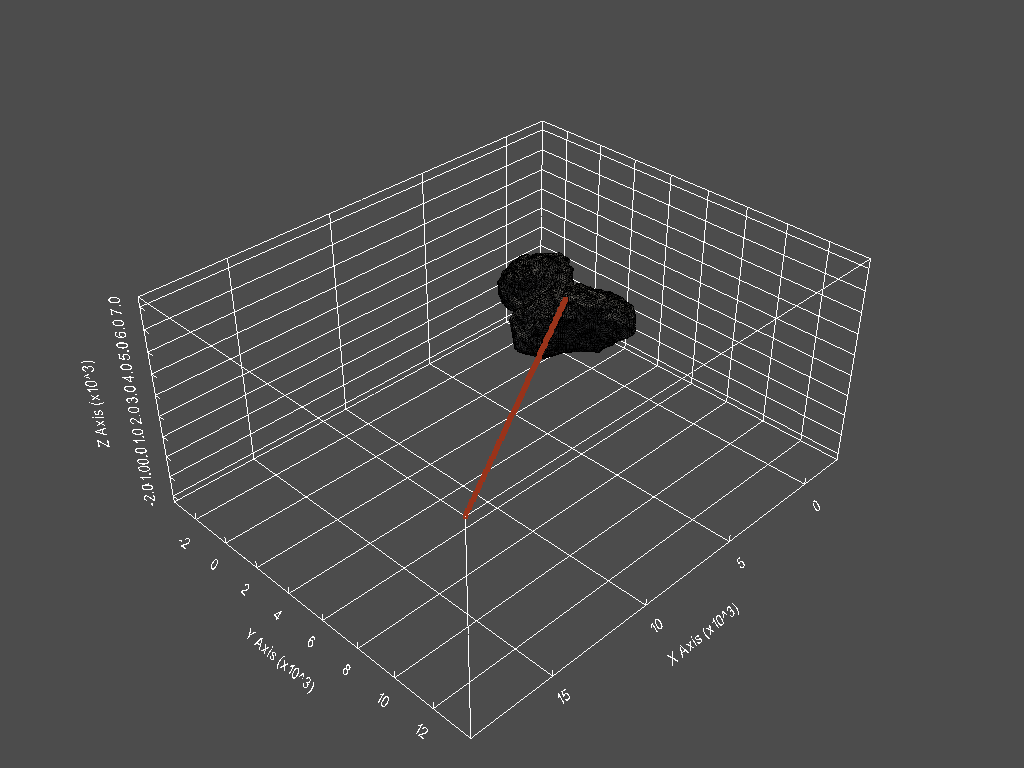

In [8]:
# Logs for output
uda = algo.extract(pg.de)
uda.get_log() 
print(pop.champion_f) 
print(pop.champion_x) 

# Retrieving champion chromosome
x = pop.champion_x

# Computing optimized trajectory
mesh, vertices, faces = mesh_utility.create_mesh()
r_store, v_store = get_trajectory(mesh, vertices, faces, x)

# Plotting trajectory
plot_trajectory(mesh, vertices, faces, r_store)